In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import warnings
warnings.filterwarnings("ignore")  

import sys
import time

from sklearn.feature_extraction.text import CountVectorizer #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer #For TF-IDF
from gensim.models import Word2Vec                          #For Word2Vec

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

###

import itertools
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.models import Sequential, Model, load_model

from keras.callbacks import ModelCheckpoint, EarlyStopping


from keras.layers import Input, Dense, Activation, Dropout, LSTM, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras import utils

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def read_data(file_path):
  data = pd.read_csv(file_path, header = 0)
  return data

In [0]:
#set the seed
seed = 1920302
np.random.seed(seed)

sad        5165
angry      5165
happy      5165
neutral    5165
Name: sentiment, dtype: int64

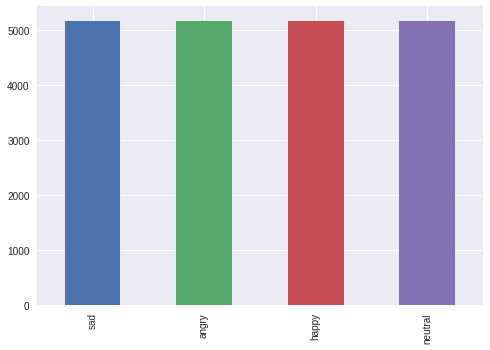

In [7]:
df = read_data("../content/drive/My Drive/Colab Notebooks/datasets/tweets_light_3.csv")
df = df.astype(str)
#Shuffle the dataframe
df = df.reindex(np.random.permutation(df.index))

df_counts = df["sentiment"].value_counts()

#Make different counts equal
s_count, h_count, n_count, a_count = [0 for _ in range(4)]
min_count = min(df_counts["happy"], df_counts["angry"], df_counts["neutral"], df_counts["sad"])
for index, row in df.iterrows():
  sentiment = row["sentiment"]
  if (sentiment == "sad"):
    if (s_count < min_count):
      s_count+=1
      continue
    else:
      df.drop(index,inplace=True)
      continue
  if (sentiment == "happy"):
    if (h_count < min_count):
      h_count+=1
      continue
    else:
      df.drop(index, inplace=True)
      continue
  if (sentiment == "neutral"):
    if (n_count < min_count):
      n_count+=1
      continue
    else:
      df.drop(index, inplace=True)
      continue
  if (sentiment == "angry"):
    if (a_count < min_count):
      a_count+=1
      continue
    else:
      df.drop(index, inplace=True)
      continue
  df.drop(index, inplace=True)
    
print()
#print(s_count, min_count)
#plot distribution of sentiments
df["sentiment"].value_counts().plot(kind='bar');
df["sentiment"].value_counts()

In [23]:
# df['target'] = df.sentiment.astype('category').cat.codes
# df['num_words'] = df.content.apply(lambda x : len(x.split()))

# bins=[0,50,75, np.inf]
# df['bins']=pd.cut(df.num_words, bins=[0,5,10,15,20, np.inf], labels=['0-5', '5-10', '10-15','15-20' ,'>20'])

# word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})

# num_class = len(np.unique(df.sentiment.values))
# y = df['target'].values

# MAX_LENGTH = 25

# tokenize = text.Tokenizer()
# tokenize.fit_on_texts(df.content.values)

# post_seq = tokenize.texts_to_sequences(df.content.values)
# post_seq_padded = sequence.pad_sequences(post_seq, maxlen=MAX_LENGTH)


# vocab_size = len(tokenize.word_index) + 1

# X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size = 0.10, random_state = 42)

# df.head()
# #print(vocab_size)


,tweet_id,sentiment,author,content,target,num_words,bins
39683,1753855045,neutral,xoAlexHeartsxo,stupid alarm lol morn twiit,2,5,0-5
10668,1962973466,sad,BunniesNBuggies,anyon els bad friday fun day today,3,7,5-10
5741,1961037030,angry,itsGAAABZ,school time cuz im sick,0,5,0-5
7856,1961912738,happy,raquellxoxo,need hug dnt feel good,1,5,0-5
27961,1696003446,sad,southernsocial,omg know give stroke everytim go get mad quiet...,3,11,10-15


In [0]:
X = df["content"]
Y = df["sentiment"]

#print(dataframes["content"])

In [9]:
#split train / test set with shuffling
#train_size = int(len(dataframes) * .8)
#X_train = df["content"][:train_size]
#Y_train = df["sentiment"][:train_size]
#X_test = df["content"][train_size:]
#Y_test = df["sentiment"][train_size:]
train_content, test_content, train_label, test_label = train_test_split(X, Y, test_size=0.2, random_state = 42)

#print(X_train)
print(test_label.value_counts())
print("Training entries: {}, labels: {}".format(len(train_content), len(train_label)))

neutral    1054
happy      1039
angry      1038
sad        1001
Name: sentiment, dtype: int64
Training entries: 16528, labels: 16528


In [0]:
#Tokenizing of the words
max_words = 3000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_content) # only fit on train, test should not be fit


In [30]:
# tf-idf
max_features=5000
tf_idf = TfidfVectorizer(max_features)
tf_data = tf_idf.fit_transform(train_content)
print(tf_data.shape)

(16528, 14156)


In [0]:
# #Tokenize the text sets
X_train = tokenize.texts_to_matrix(train_content)
X_test = tokenize.texts_to_matrix(test_content)

In [0]:
#Transform text labels to hot-encoded matrix labels
# angry, happy, neutral, sad
# 1. 0. 0. 0. 
# 0. 1. 0. 0.
# 0. 0. 1. 0.
# 0. 0. 0. 1.
encoder = LabelEncoder()
encoder.fit(train_label)
Y_train = encoder.transform(train_label)
Y_test = encoder.transform(test_label)

num_classes = np.max(Y_train) + 1
Y_train = utils.to_categorical(Y_train, num_classes)
Y_test = utils.to_categorical(Y_test, num_classes)

#print(Y_train)
#print(train_label)


In [37]:
batch_size = 32 #2085 * 5 = 10425
epochs = 8

# Build the model
# https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) #The softmax function

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()
filepath="../content/drive/My Drive/Colab Notebooks/weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[checkpointer])

score = model.evaluate(X_test, Y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

model.save("../content/drive/My Drive/Colab Notebooks/models/model-simple.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 512)               1536512   
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 2052      
_________________________________________________________________
activation_19 (Activation)   (None, 4)                 0         
Total params: 1,538,564
Trainable params: 1,538,564
Non-trainable params: 0
_________________________________________________________________
Train on 14875 samples, validate on 1653 samples
Epoch 1/8
14875/14875 [==============================] - 18s 1ms/step - loss: 1.272

In [0]:
# Implementation testings

# batch_size = 32 #2085 * 5 = 10425
# epochs = 6

# # Build the model
# # https://keras.io/getting-started/sequential-model-guide/
# model = Sequential()


# model.add(Dense(512, input_shape=(max_words,)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(250))
# model.add(Dropout(0.2))
# model.add(Activation('relu'))
          
# # Projecting into output layer
# model.add(Dense(num_classes))
# model.add(Activation('softmax')) #The softmax function

# #Trying different optimizers, current = Adamax, Adadelta
# model.compile(loss='categorical_crossentropy',
#               optimizer='Adadelta',
#               metrics=['accuracy'])
              
# history = model.fit(X_train, Y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.1)

# score = model.evaluate(X_test, Y_test,
#                        batch_size=batch_size, verbose=1)
# print('Test accuracy:', score[1])


In [0]:
# del model

# inputs = Input(shape=(MAX_LENGTH, ))
# embedding_layer = Embedding(vocab_size,
#                             128,
#                             input_length=MAX_LENGTH)(inputs)

# x = LSTM(64)(embedding_layer)
# x = Dense(32, activation='relu')(x)
# predictions = Dense(num_class, activation='softmax')(x)
# model = Model(inputs=[inputs], outputs=predictions)
# model.compile(optimizer='adadelta',
#               loss='categorical_crossentropy',
#               metrics=['acc'])

# model.summary()

# filepath="../content/drive/My Drive/Colab Notebooks/weights-rnn.hdf5"
# checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# history = model.fit([X_train], batch_size=64, y=utils.to_categorical(y_train), verbose=1, validation_split=0.25, 
#           shuffle=True, epochs=5, callbacks=[checkpointer])

# df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
# g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
# g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [0]:
# inputs = Input(shape=(MAX_LENGTH, ))
# embedding_layer = Embedding(vocab_size,
#                             128,
#                             input_length=MAX_LENGTH)(inputs)
# x = Flatten()(embedding_layer)
# x = Dense(32, activation='relu')(x)
# x = Dropout(0.2)(x)

# predictions = Dense(num_class, activation='softmax')(x)
# model = Model(inputs=[inputs], outputs=predictions)

# #load weights before compiling
# #model.load_weights("../content/drive/My Drive/Colab Notebooks/weights-simple_light3.hdf5")

# model.compile(optimizer='adadelta',
#               loss='categorical_crossentropy',
#               metrics=['acc'])

# model.summary()
# filepath="../content/drive/My Drive/Colab Notebooks/weights-simple.hdf5"
# checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# history = model.fit([X_train], batch_size=64, y=utils.to_categorical(y_train), verbose=1, validation_split=0.25, 
#           shuffle=True, epochs=5, callbacks=[checkpointer])

# daf = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
# g = sns.pointplot(x="epochs", y="accuracy", data=daf, fit_reg=False)
# g = sns.pointplot(x="epochs", y="validation_accuracy", data=daf, fit_reg=False, color='green')

# predicted = model.predict(X_test)
# predicted = np.argmax(predicted, axis=1)
# accuracy_score(y_test, predicted)